# Matching

## Описание проекта

**Matching** - это задача поиска и сопоставления двух объектов из разных наборов данных. Такая потребность возникла у маркетплейса, который имеет большой перечен товаров для продажи. На склад стали поступать новые партии товаров, которые имеет небольшие отличия в характеристиках. Технически, это выглядит как совершенно новые товары. Фактически это те же товары, которые уже продаются на маркетплейсе. Задача сопоставить и связать новые товары со старыми, пользуясь совпадающими характеристиками.

**Что надо сделать?**
- разработать алгоритм, который для всех товаров из _validation.csv_ предложит несколько вариантов наиболее похожих товаров из base;
- оценить качество алгоритма по метрике `accuracy@5`.

$$
accuracy@n = \frac{\text{кол-во верных соотношений (из n кандидатов)}} {\text{n (общее кол-во кандидатов)}} * 100\%
$$

Именно в _предложении 5 кандидатов_ для соотношения и заключается отличительная черта данной метрики.

**Данные:**

- *base.csv* - анонимизированный набор товаров. Каждый товар представлен как уникальный **id** (`0-base, 1-base, 2-base, …`) и вектор признаков размерностью 72.
- *train.csv -* обучающий датасет. Каждая строчка - один товар, для которого известен уникальный **id** (`0-query, 1-query, …`) , вектор признаков И id товара из *base.csv*, который максимально похож на него (по мнению экспертов).
- *validation.csv* - датасет с товарами (уникальный **id** и вектор признаков), для которых надо найти наиболее близкие товары из *base.csv*
- *validation_answer.csv* - правильные ответы к предыдущему файлу.

**План работы:**
- Этап 1. Разведочный анализ данных (EDA):
  - 1.1 Подключение библиотек;
  - 1.2 Загрузка данных из файла;
  - 1.3 Первичный осмотр данных:
   - Base;
   - Train;
   - Valid.
  - 1.4 Исследование мультиколлинеарности;
  - Промежуточный вывод.
- Этап 2. Масштабирование признаков;
- Этап 3. Поиск ближайших соседей;
- Этап 4. Ранжирование:
 - 4.1 Отбор гиперпараметров с помощью optuna.
- Этап 5. Проверка на тестовой выборке.
- Вывод.

___

## Этап 1. Разведочный анализ данных (EDA)

### 1.1 Подключение библиотек

В библиотеке [Scikit-Learn](https://scikit-learn.org/stable/modules/neighbors.html#unsupervised-neighbors) существует метод поиска ближайших соседей, но весьма ресурсоёмкий. Так как исходный датасет имеет большой объём можно упростить работу делением всех объектов на кластеры с помощью центроидов. В этом проекте будет использована библиотека [Faiss](https://faiss.ai/index.html).

In [ ]:
%pip install -q optuna faiss-cpu phik

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# импорт библиотек
import phik
import faiss
import optuna
import lightgbm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# импорт спец. модулей
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, ConfusionMatrixDisplay

# константы
RANDOM_STATE = 42  # фиксация случайности
N_CLUSTERS   = 200 # кол-во кластеров для деления векторного пространства
K_NEIGHBORS  = 100 # кол-во ближайших соседей
N_CELLS      = 5   # конечное кол-во кандидатов на сопоставление
DATA_DIR =   './'

# Устанавливаем максимальное количество отображаемых колонок равным None (без ограничений)
pd.set_option('display.max_columns', None)

### 1.2 Загрузка данных из файла

In [ ]:
%%time
# чтение датасетов
base_df       = pd.read_csv(DATA_DIR + 'base.csv')
train_df      = pd.read_csv(DATA_DIR + 'train.csv')
valid_df      = pd.read_csv(DATA_DIR + 'validation.csv')
valid_targets = pd.read_csv(DATA_DIR + 'validation_answer.csv')

CPU times: user 29.8 s, sys: 2.73 s, total: 32.5 s
Wall time: 41.8 s


Необходимо привести названия колонок к нижнему регистру и назначить индексацию **id** товаров: `0-base, 1-base, ... или 0-query, 1-query, ...`

In [ ]:
# стандартизация названий колонок и смена индексации
for df in [base_df, train_df, valid_df, valid_targets]:
    df.columns = df.columns.str.lower()
    df.set_index('id', inplace=True)

Для упрощения работы в следующей ячейке кода будет описана функция, которая выводит матрицу из графиков распределения значений всех колонок датасета. На вход она принимает один из исходных датасетов, и кол-во строк и столбцов в матрице. Для этих параметров уже заданы значения по-умолчанию, для вывода 72 графиков.

In [ ]:
# Функция построения графиков распределения значений в колонках датасета

def show_graph_matrix(dataframe, color='blue', x=6, y=12, sample_size_percent=10):
    """
    Функция построения графиков распределения значений в колонках датасета, используя процентную подвыборку для каждого признака.

    Аргументы:
    dataframe : pandas.DataFrame
        Датафрейм, содержащий данные.
    color : str, optional
        Цвет графиков. По умолчанию 'blue'.
    x : int, optional
        Количество колонок для построения графиков по оси x. По умолчанию 6.
    y : int, optional
        Количество колонок для построения графиков по оси y. По умолчанию 12.
    sample_size_percent : int, optional
        Процент от общего числа строк, который будет использоваться для подвыборки данных каждого признака. По умолчанию 10.
    """
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))
    total_columns = len(dataframe.columns)

    # Определяем общее количество подграфиков для корректного завершения цикла
    total_plots = min(total_columns, x * y)

    for n in range(total_plots):
        col = dataframe.columns[n]
        i, j = divmod(n, x)

        # Вычисляем размер подвыборки в строках
        sample_size = int(len(dataframe) * sample_size_percent / 100)
        # Выбираем подвыборку данных
        sample_data = dataframe[col].sample(n=sample_size, random_state=1) if len(dataframe) > sample_size else dataframe[col]
        data = sample_data.value_counts().reset_index().sort_values(by='index', ascending=True)
        data.columns = ['value', 'count']

        axs[i, j].plot(data['value'], data['count'], marker='.', linestyle='', color=color)
        axs[i, j].set_title(f'Значения признака №{col}')

    # Выключаем оси для подграфиков, которые не используются
    for k in range(total_plots, x*y):
        i, j = divmod(k, x)
        axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

Для детального анализа конкретных колонок ниже описана функция, которая выводит top-5 популярных значений (и частоту их повторений), а так же графики распределения этих значений в разных масштабах (общий и увеличенный).

In [ ]:
# Функция для подробного анализа значений колонки

def value_analysis(dataframe, column:str, ylim_max:float, color='blue'):
    """
    Функция анализа значений в указанной колонке датафрейма и построения графика их распределения.

    Аргументы:
    dataframe : pandas.DataFrame
        Датафрейм, содержащий данные.
    column : str
        Название колонки для анализа.
    ylim_max : float
        Максимальное значение по оси y на втором графике.
    color : str, optional
        Цвет графиков. По умолчанию 'blue'.
    """
    print('Наиболее популярные значения')
    display((dataframe[column].value_counts(normalize=True)
                              .sort_values(ascending=False)*100)
                              .to_frame()
                              .rename(columns={column:'values','proportion':'frequency, %'})
                              .head())

    fig, axs = plt.subplots(1, 2, figsize=(18, 6))
    axs[0].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='.', linestyle='', color=color)
    axs[0].set_title('График распределения значений колонки №' + column + ' (общий вид)')
    axs[0].set_ylabel('Доля объектов от общего количества, %')
    axs[0].set_xlabel('Значения признака №' + column)
    axs[0].grid()

    axs[1].plot((dataframe[column].value_counts(normalize=True).sort_index() * 100), marker='o', linestyle='', color=color)
    axs[1].set_title('График распределения значений колонки №' + column + ' (увеличенный вид)')
    axs[1].set_ylabel('Доля объектов от общего количества, %)')
    axs[1].set_xlabel('Значения признака №' + column)
    axs[1].set_ylim(0, ylim_max)
    axs[1].grid()
    plt.show()

Для удобного сравнения данны и их распределений из всех датасетов, ниже описана функция выводящая матрицу из графиков по аналогии с функцией `show_graph_matrix`

In [ ]:
# Функция построения графиков распределения значений всех датасетов

def show_general_matrix(df_1, df_2, df_3, x=6, y=12, sample_size_percent=10):
    """
    Функция построения общей матрицы графиков распределения значений для трех датафреймов.

    Аргументы:
    df_1 : pandas.DataFrame
        Первый датафрейм.
    df_2 : pandas.DataFrame
        Второй датафрейм.
    df_3 : pandas.DataFrame
        Третий датафрейм.
    x : int, optional
        Количество колонок для построения графиков по оси x. По умолчанию 6.
    y : int, optional
        Количество колонок для построения графиков по оси y. По умолчанию 12.
    sample_size_percent : int, optional
        Процент от общего числа строк, который будет использоваться для подвыборки данных каждого признака. По умолчанию 10.
    """
    fig, axs = plt.subplots(y, x, figsize=(x*4, y*4))

    common_columns = list(set(df_1.columns) & set(df_2.columns) & set(df_3.columns))
    common_columns.sort()  # Сортировка для гарантии одинакового порядка

    # Определение размера подвыборки
    sample_size_1 = int(len(df_1) * sample_size_percent / 100)
    sample_size_2 = int(len(df_2) * sample_size_percent / 100)
    sample_size_3 = int(len(df_3) * sample_size_percent / 100)

    for n, col in enumerate(common_columns):
        # Вычисляем индекс подграфика
        i, j = divmod(n, x)
        if i >= y:  # Если достигли лимита по оси y, прекращаем отрисовку
            break

        # Получение подвыборки для каждого датафрейма
        sub_df_1 = df_1[col].sample(n=sample_size_1, random_state=1)
        sub_df_2 = df_2[col].sample(n=sample_size_2, random_state=1)
        sub_df_3 = df_3[col].sample(n=sample_size_3, random_state=1)

        # Построение графиков
        data_1 = sub_df_1.value_counts(normalize=True).sort_index() * 100
        data_2 = sub_df_2.value_counts(normalize=True).sort_index() * 100
        data_3 = sub_df_3.value_counts(normalize=True).sort_index() * 100

        axs[i, j].plot(data_1.index, data_1.values, marker='o', linestyle='', color='lightblue', label='df_1')
        axs[i, j].plot(data_2.index, data_2.values, marker='+', linestyle='', color='red', label='df_2')
        axs[i, j].plot(data_3.index, data_3.values, marker='x', linestyle='', color='lightgreen', label='df_3')
        axs[i, j].set_title(f'Значения признака №{col}')
        axs[i, j].legend()

    plt.tight_layout()
    plt.show()

### 1.3 Первичный осмотр данных

#### Base

`Base` - набор из всех товаров (когда либо продававшихся на маркетплейсе) и 72 колонки с их характеристиками. Фактическое значение этих характеристик не имеет значения в рамках этого проекта. Эти данные прошли предварительную обработку (анонимизацию). По этой причине значения выглядят совершенно абстрактными на первый взгляд.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,-124.06151,-32.458237,-57.420560,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.939090,1507.231274,-32.591667,51.414360,-51.905360,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.773180,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.020390,59.794296,78.106380,-89.375725,89.412100,79.812180,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,-141.30435,-126.768900,-68.853530,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.788040,429.880035,-5.937690,70.142654,66.576840,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.914630,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.171060,-56.711540,63.542606,-121.319170,97.426056,74.832840,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,-140.82245,-22.486748,-51.666990,2.521726,140.58545,-22.039230,-7.128634,-5.184787,-111.71212,-79.02927,-82.452576,1507.231274,-0.421011,84.108010,63.344510,813.770071,-105.211050,18.844700,-94.789474,151.38771,-21.483440,-144.84537,48.502934,-780.449185,64.767310,79.781555,-13.390142,-150.06166,-118.75855,-40.896286,-15.222620,-1.860338,-93.820656,98.749070,-46.745782,65.927475,-10.286392,-125.32137,21.048609,-22.637775,68.915985,-54.902260,66.335470,-142.927920,83.030980,69.979630,-123.73389,65.320880,-114.03718,-529.396956,-101.581375,-134.65822,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,-108.47044,-104.537780,-82.388490,-79.986740,113.59631,-38.995880,-4.787360,8.327808,-124.85576,-79.10902,-107.943275,1479.170530,-125.271614,24.656485,-16.921055,813.770071,-182.680270,14.715704,-62.932700,151.20198,10.613454,-134.93434,58.777730,-529.295053,43.665924,92.806305,-38.936657,-145.04530,-124.29577,-36.876730,-17.742870,10.536242,-124.584150,121.914150,-17.321358,105.217240,-94.379650,-63.76927,29.217487,-26.423973,5.869829,64.061550,63.513280,-112.258100,80.926590,72.636100,-137.31432,7.912551,-62.18892,-540.321044,-89.588715,-149.32669,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,-110.34245,-38.982060,-50.228867,-26.690920,135.27290,-7.510103,8.924209,111.576950,-130.83319,-79.31585,-57.843952,1262.919738,19.225910,59.811813,76.159670,312.698903,-76.726974,21.299923,-24.069107,167.38553,-44.059470,-148.13185,98.042610,-657.524388,96.363170,71.061520,-36.563557,-135.37244,-123.70898,-44.739437,-10.855220,8.354800,-168.328860,215.928070,-32.975979,66.864880,30.838630,-211.54037,57.695343,-67.822630,-29.389133,-34.123740,54.710550,-26.032013,90.673910,58.086998,-134.78206,77.62

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   0       2918139 non-null  float64
 1   1       2918139 non-null  float64
 2   2       2918139 non-null  float64
 3   3       2918139 non-null  float64
 4   4       2918139 non-null  float64
 5   5       2918139 non-null  float64
 6   6       2918139 non-null  float64
 7   7       2918139 non-null  float64
 8   8       2918139 non-null  float64
 9   9       2918139 non-null  float64
 10  10      2918139 non-null  float64
 11  11      2918139 non-null  float64
 12  12      2918139 non-null  float64
 13  13      2918139 non-null  float64
 14  14      2918139 non-null  float64
 15  15      2918139 non-null  float64
 16  16      2918139 non-null  float64
 17  17      2918139 non-null  float64
 18  18      2918139 non-null  float64
 19  19      2918139 non-null  float64
 20  20      2918139 non

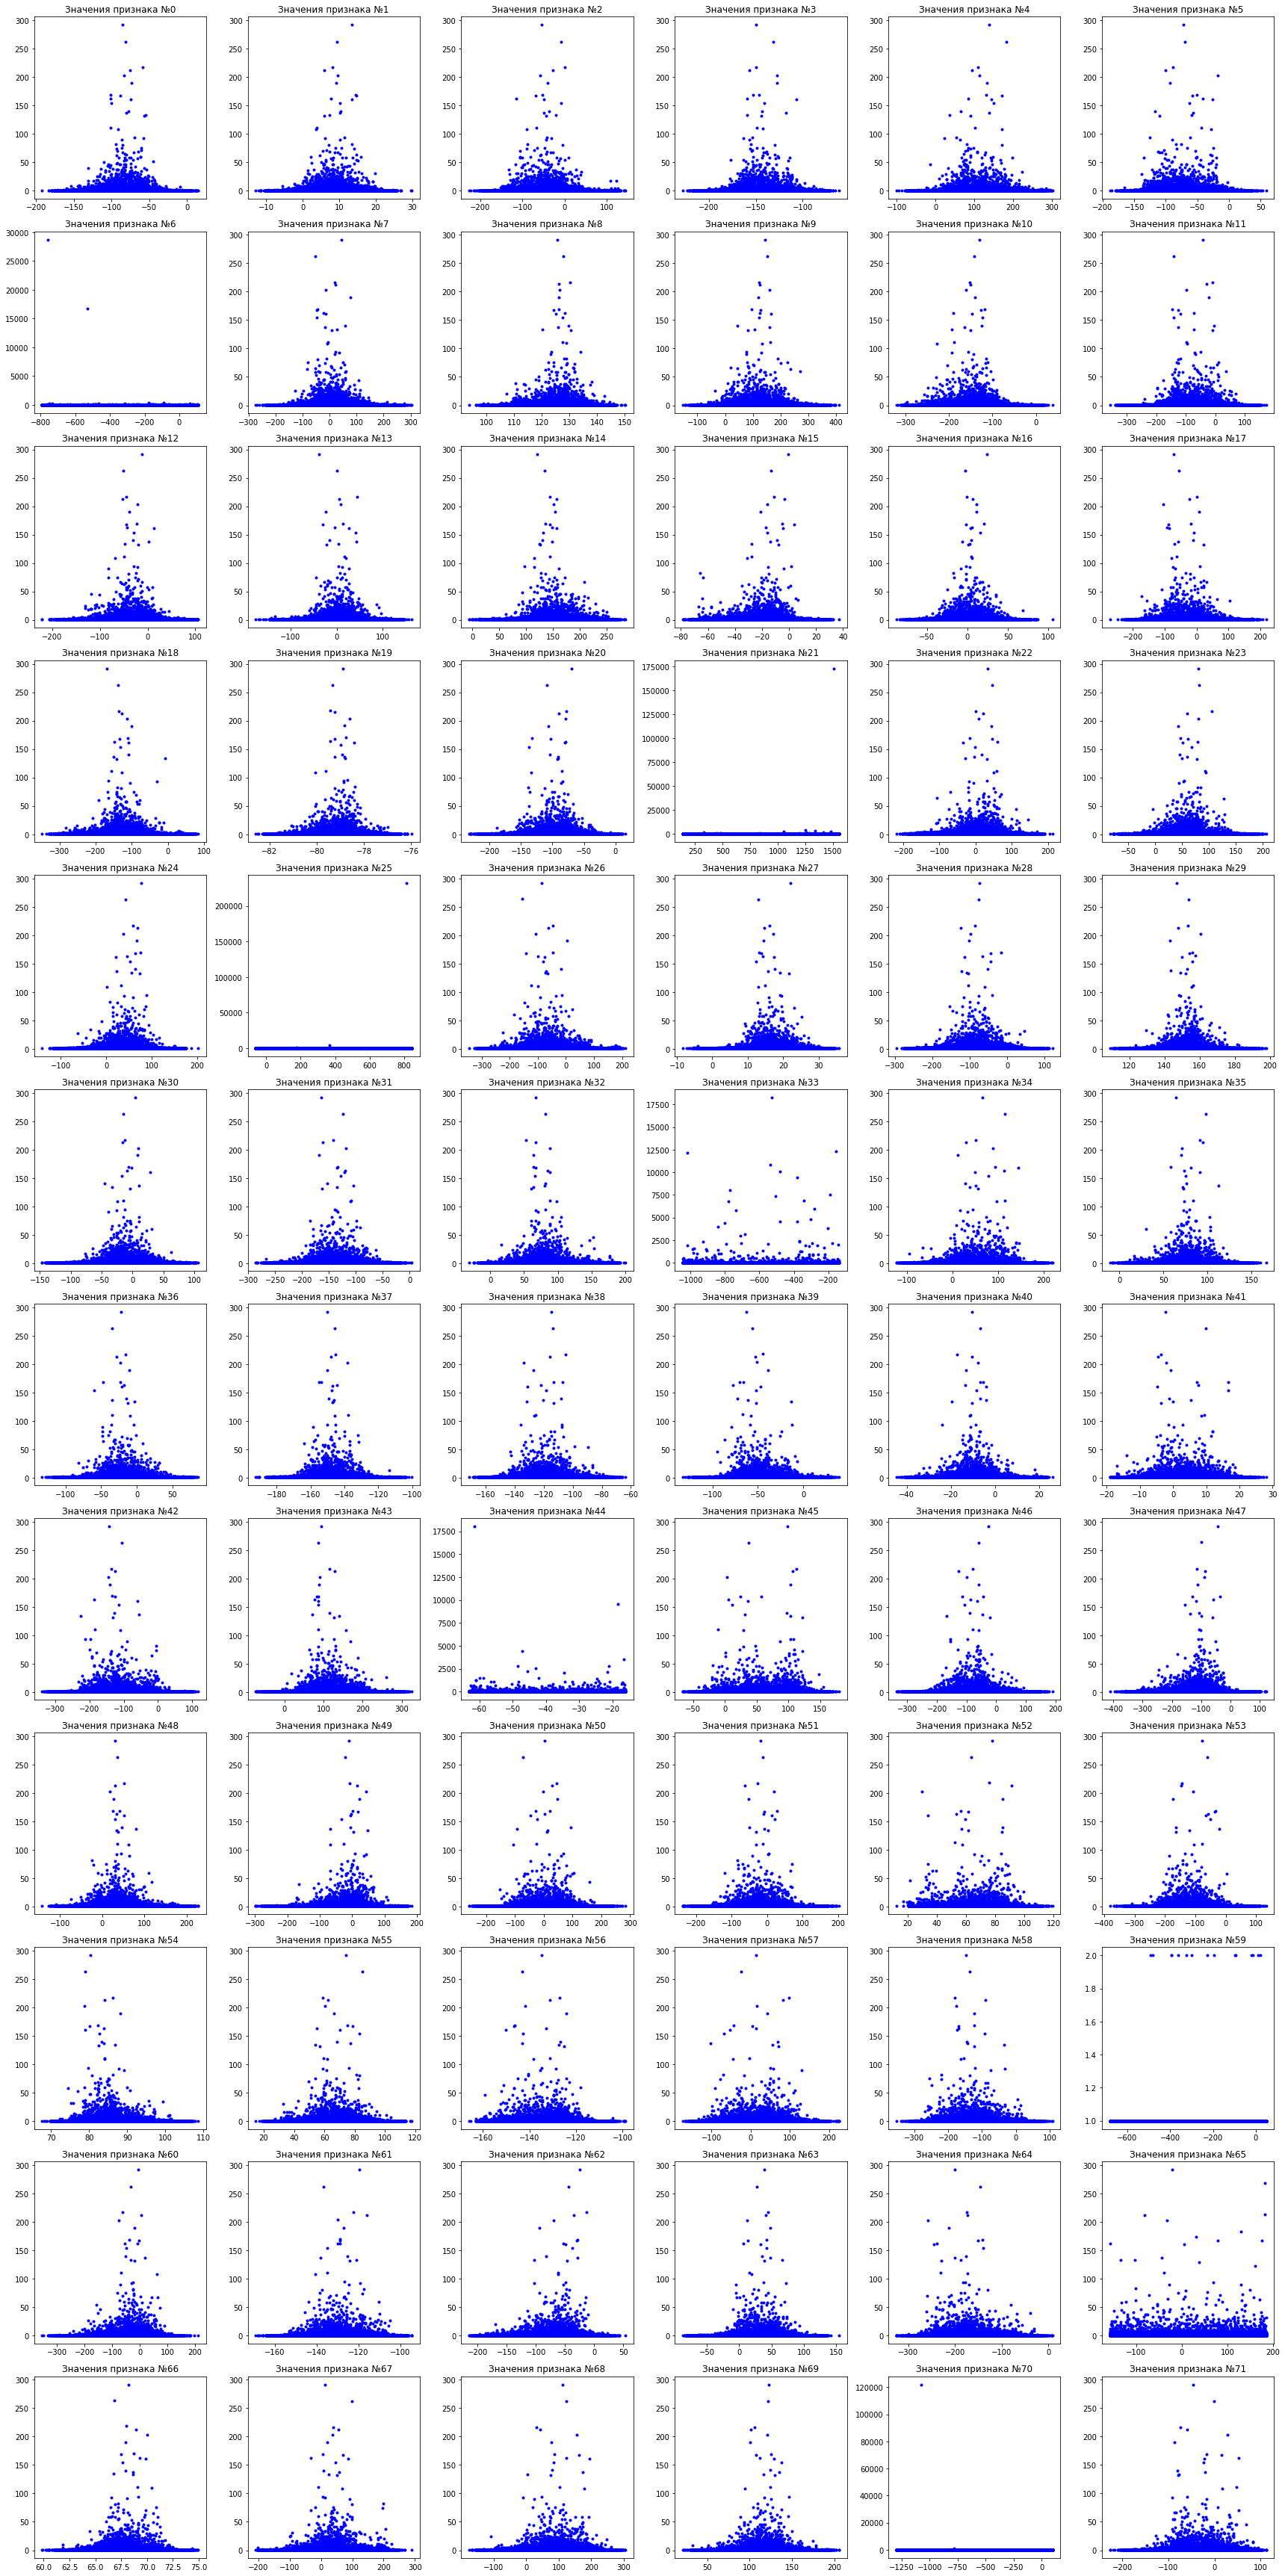

CPU times: user 1min 6s, sys: 5.24 s, total: 1min 11s
Wall time: 1min 11s


In [ ]:
%%time
display(base_df.head())
print(base_df.info(verbose=True, show_counts=True))
print('Кол-во товаров-дубликатов:', base_df.duplicated().sum())
show_graph_matrix(base_df)

Большинство данных имеют вид _нормального распределения_ или очень схожего. В каждой колонке свой диапазон значений (широкий/узкий), встречаются как положительные та и отрицательные значения. Отдельное внимание стоит уделить столбцам № `6, 21, 25, 33, 44, 45, 59, 65, 70`.

In [ ]:
# Удалим колонки, который приводят к шуму в данных.
base_df.drop(columns=['6', '21', '25', '33', '44', '45', '59', '65', '70'], inplace=True)

#### Train

`Train` - набор из товаров новых поставок, для которых известны соответствующие товары из "старого" датасета base. ID этого товара содержится в отдельном датасете target.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.512180,-94.42894,898.436927,-70.140520,78.420360,108.032776,813.770071,-74.790880,12.610422,-183.821840,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.250950,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.969920,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.513820,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.659430,-92.76149,353.157741,-34.744545,82.487110,-28.450592,813.770071,-137.529630,26.595627,-136.783450,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.636870,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.915470,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.632110,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,-86.34656,-35.666546,16.395317,-80.802850,137.908650,-23.532760,-47.256584,-16.650242,-194.50568,-78.372925,-69.32448,1507.231274,-52.500970,-34.165775,52.958652,813.770071,-18.021725,20.951107,-50.321780,158.76062,0.178065,-183.06967,99.053570,-1018.469545,-51.80112,97.766770,-10.865850,-144.42316,-133.819490,-78.902300,-17.200352,4.467452,-63.970737,154.63953,-30.211614,48.527400,-122.406640,-112.71362,53.461838,-31.117260,107.84151,16.482935,77.934480,-95.61873,91.460075,63.119510,-126.93925,8.066627,-195.677670,-163.120000,-72.830000,-139.22307,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,-146.51707,-159.469850,-13.844755,-6.113928,118.939255,-44.585907,9.559358,14.435648,-156.90683,-78.789320,-78.73709,1507.231274,19.957405,34.834290,-8.820732,813.770071,-125.606800,17.584084,-58.452904,141.28180,-54.959310,-136.98854,63.880493,-1018.469545,89.22893,65.919960,-24.078644,-152.33410,-91.199380,-28.225390,-4.767386,0.158236,-129.128660,122.95837,-30.800995,123.623400,-37.540867,-72.13980,71.240990,-168.115590,118.23645,-18.065195,37.255720,-137.69104,87.500770,62.437290,-131.26064,35.692660,-86.038830,-379.339090,-153.465770,-131.19829,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,-107.15302,-8.800034,-50.977800,29.457338,143.389310,5.614824,-45.274760,9.643625,-77.55463,-79.066610,-77.92646,1507.231274,16.612400,116.284290,33.754898,813.770071,-105.765335,6.523008,-19.812988,157.69392,-20.604088,-146.59128,78.849570,-780.449185,87.56077,73.036660,16.891030,-144.65790,-116.122150,-19.353254,-7.709266,-5.394988,-140.252120,193.18497,-53.147078,79.869446,-151.131350,-45.05616,79.796234,46.763016,47.68181,-

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

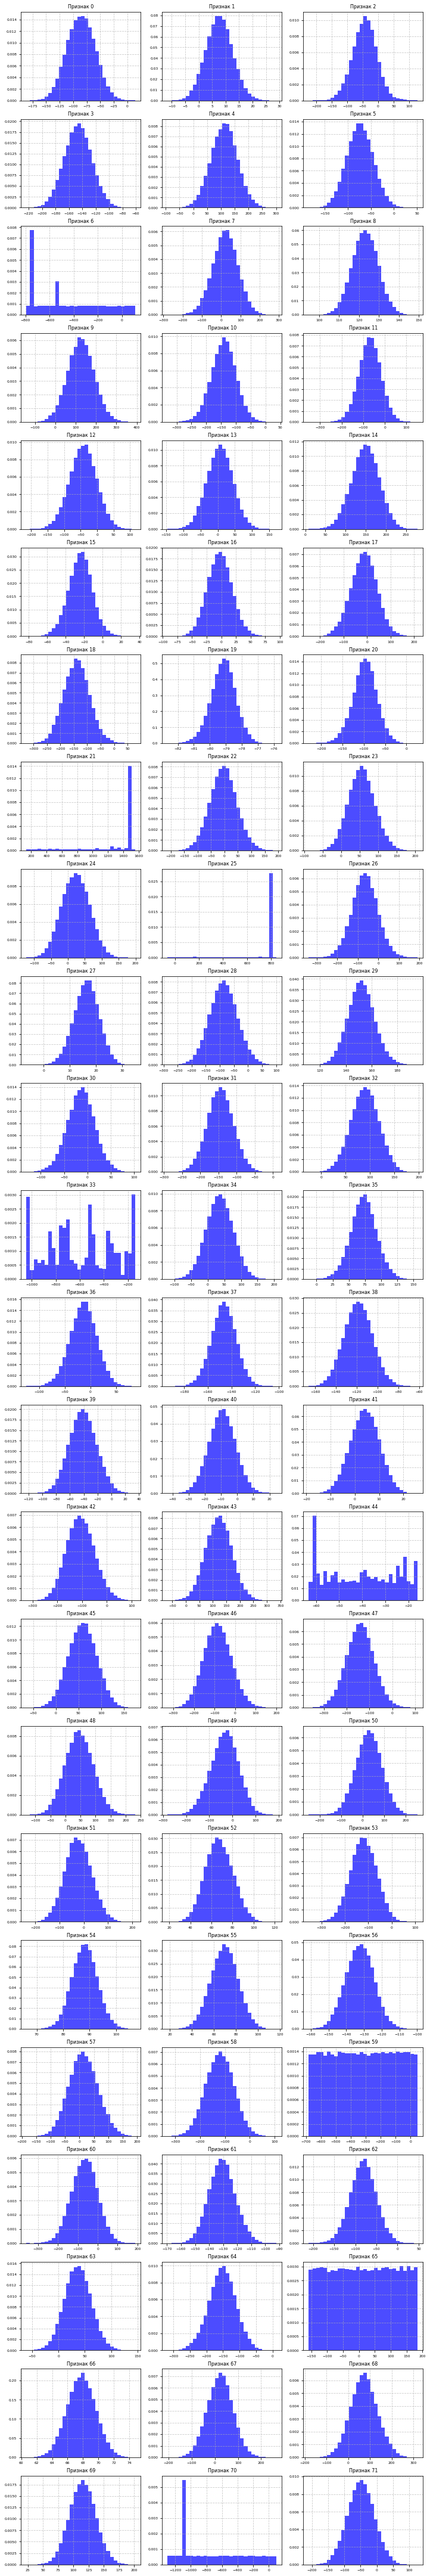

CPU times: user 10.2 s, sys: 512 ms, total: 10.7 s
Wall time: 10.2 s


In [ ]:
%%time
# вывод общей информации
display(train_df.head())
train_df.info()
print('Кол-во товаров-дубликатов:', train_df.duplicated().sum())

# Настройка размера шрифта для графиков
plt.rc('font', size=6)
plt.rc('axes', titlesize=8)     # Размер заголовков осей
plt.rc('axes', labelsize=6)     # Размер меток осей
plt.rc('xtick', labelsize=6)    # Размер меток делений на оси X
plt.rc('ytick', labelsize=6)    # Размер меток делений на оси Y

# Создание фигуры с 24 строками и 3 столбцами подграфиков
fig, axs = plt.subplots(24, 3, figsize=(10, 60))

# Убедимся, что индекс подграфика не выходит за рамки массива
for idx, col in enumerate(train_df.columns):
    # Получаем индекс строки и столбца для текущего графика
    row_idx = idx // 3
    col_idx = idx % 3

    # Проверяем, что индекс строки не выходит за границы
    if row_idx < 24:
        ax = axs[row_idx, col_idx]
        ax.hist(train_df[col], bins=30, color='blue', alpha=0.7, density=True)
        ax.set_title(f'Признак {col}')
        ax.grid(True, linestyle='--', alpha=0.7)  # Добавление сетки с прозрачностью
    else:
        break  # Прекращаем цикл, если достигли конца массива подграфиков

# Применяем автоматическое улучшение расположения подграфиков
plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
# Удалим колонки, который приводят к шуму в данных.
train_df.drop(columns=['6', '21', '25', '33', '44', '45', '59', '65', '70'], inplace=True)

In [ ]:
# выделение цел. признака из обучающей выборки
train_targets = train_df['target']
train_df.drop('target', axis=1, inplace=True)

Тренировочные данные имеют аналогичный вид как в base.csv. Значения параметров №№ `6, 21, 25, 44, 45, 59, 65, 70` распределены равномерно на всём диапазоне. Встречаются особо популярные значения. Большинство данных имеют вид _нормального распределения_ или очень схожего.

#### Valid

`Valid` - набор из товаров новых поставок, для которых НЕ известны соответствующие товары и их необходимо найти.

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.968570,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.579520,263.363136,56.266876,66.924710,21.609911,813.770071,-32.782940,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.283660,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.038350,-62.643830,-5.012346,11.984920,-43.084946,190.124000,-24.996636,76.153900,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.951330,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.055480,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.860340,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.483240,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.792920,-36.076176,-2.781422,2.283144,-142.477890,189.953950,-18.408230,90.517050,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,-220.30954,-31.378445,-8.788761,2.285323,133.26611,-41.309080,14.305538,-18.231812,-205.53370,-78.160310,-96.607670,1507.231274,-5.964200,34.937443,-56.086887,813.770071,-13.200474,18.966661,-35.110190,151.36850,-17.490252,-145.884300,15.533379,-655.395514,39.412827,62.554955,9.924992,-143.93462,-123.107796,-37.032475,-13.501337,12.913328,-116.038020,176.276150,-45.909942,103.491360,-90.65699,-162.61570,117.128235,13.079479,69.826890,-6.874451,63.707214,-123.851070,91.610820,59.760067,-129.56618,-12.822194,-154.197650,-407.199067,5.522629,-126.81297,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,-114.27196,-71.406456,-65.349320,24.377070,50.46730,-14.721335,15.069309,-46.682995,-176.60437,-78.690700,-139.227450,325.547112,3.632292,74.929504,-4.802103,813.770071,-52.982597,15.644381,-54.087467,151.30914,21.088570,-134.507890,65.118960,-529.295053,131.565520,67.642700,-22.884491,-145.90652,-86.917330,-11.863579,-22.188885,0.463720,-212.533750,170.522580,-48.092532,99.712555,-194.69241,-141.52318,60.217050,73.386380,118.567856,58.900810,55.569030,-181.091660,83.340485,66.083240,-114.04887,-57.156870,-56.335075,-318.680065,-15.984783,-128.10133,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,-76.21417,-26.393860,34.423640,50.938890,157.68318,-23.786497,-33.175415,-0.592607,-193.31854,-79.651030,-91.889786,1358.481072,44.027733,121.527210,46.183000,433.623103,-82.233200,21.068508,-32.940117,149.26895,0.404718,-97.674530,81.719990,-825.644804,9.397169,49.359340,17.725466,-160.16815,-129.367950,-55.532898,-2.597821,-0.226103,-41.369140,92.090195,-58.626857,73.655440,-10.25737,-175.65678,25.395056,47.874825,51.464676,140.951680,58.751133,-215.487640,91.255

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

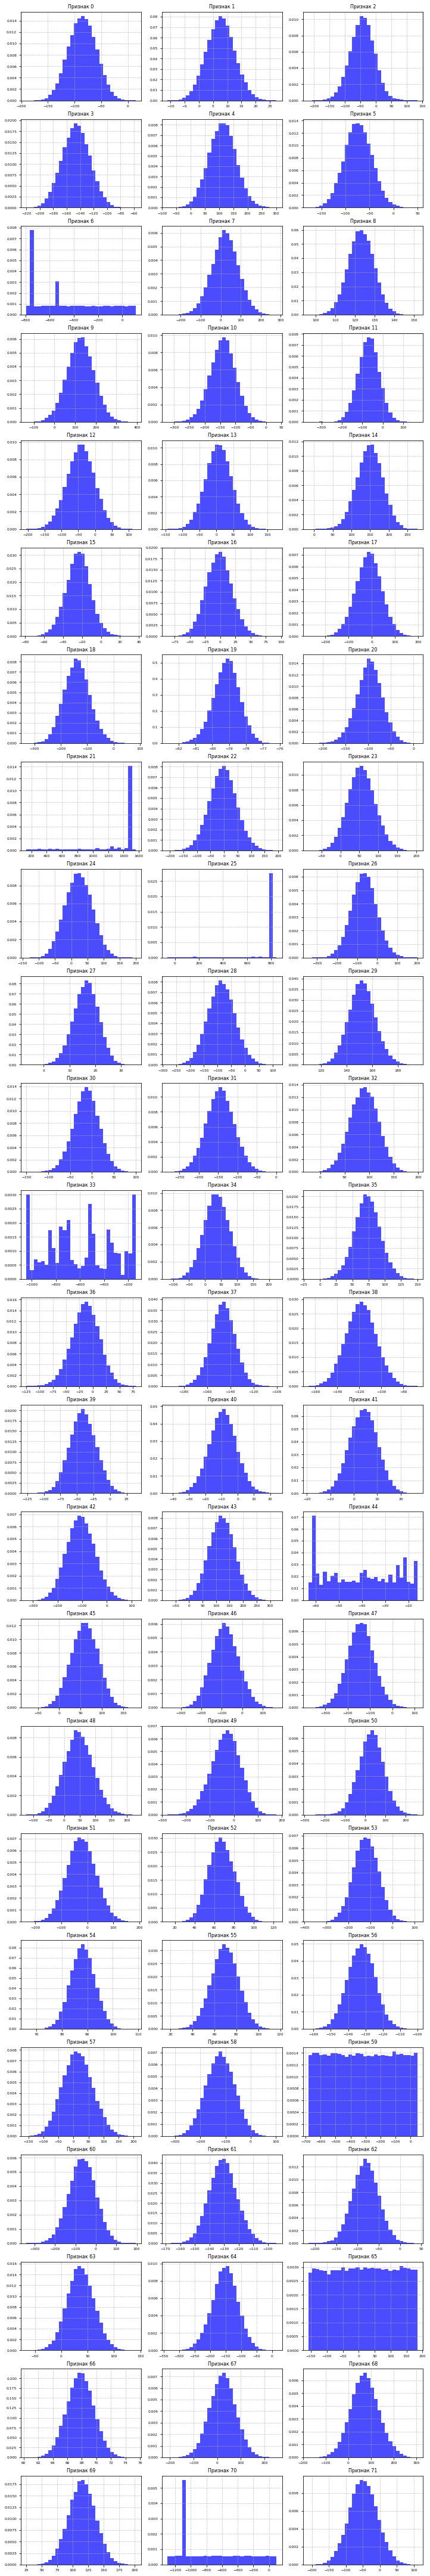

CPU times: user 10.3 s, sys: 550 ms, total: 10.8 s
Wall time: 10.4 s


In [ ]:
%%time
# вывод общей информации
display(valid_df.head())
valid_df.info()
print('Кол-во товаров-дубликатов:', valid_df.duplicated().sum())

# Настройка размера шрифта для графиков
plt.rc('font', size=6)
plt.rc('axes', titlesize=8)     # Размер заголовков осей
plt.rc('axes', labelsize=6)     # Размер меток осей
plt.rc('xtick', labelsize=6)    # Размер меток делений на оси X
plt.rc('ytick', labelsize=6)    # Размер меток делений на оси Y

# Создание фигуры с 24 строками и 3 столбцами подграфиков
fig, axs = plt.subplots(24, 3, figsize=(10, 60))

# Убедимся, что индекс подграфика не выходит за рамки массива
for idx, col in enumerate(valid_df.columns):
    # Получаем индекс строки и столбца для текущего графика
    row_idx = idx // 3
    col_idx = idx % 3

    # Проверяем, что индекс строки не выходит за границы
    if row_idx < 24:
        ax = axs[row_idx, col_idx]
        ax.hist(valid_df[col], bins=30, color='blue', alpha=0.7, density=True)
        ax.set_title(f'Признак {col}')
        ax.grid(True, linestyle='--', alpha=0.7)  # Добавление сетки с прозрачностью
    else:
        break  # Прекращаем цикл, если достигли конца массива подграфиков

# Применяем автоматическое улучшение расположения подграфиков
plt.tight_layout(pad=1.0)
plt.show()

In [ ]:
# Удалим колонки, который приводят к шуму в данных.
valid_df.drop(columns=['6', '21', '25', '33', '44', '45', '59', '65', '70'], inplace=True)

Для того, чтобы не анализировать каждый столбец по отдельности можно воспользоваться функцией `show_general_matrix`. Она позволяет соотнести данные всех датасетов и сравнить на сколько они похожи.

,Датасет,Цвет,Символ
0,base_df,blue,.
1,train_df,red,+
2,valid_df,green,x


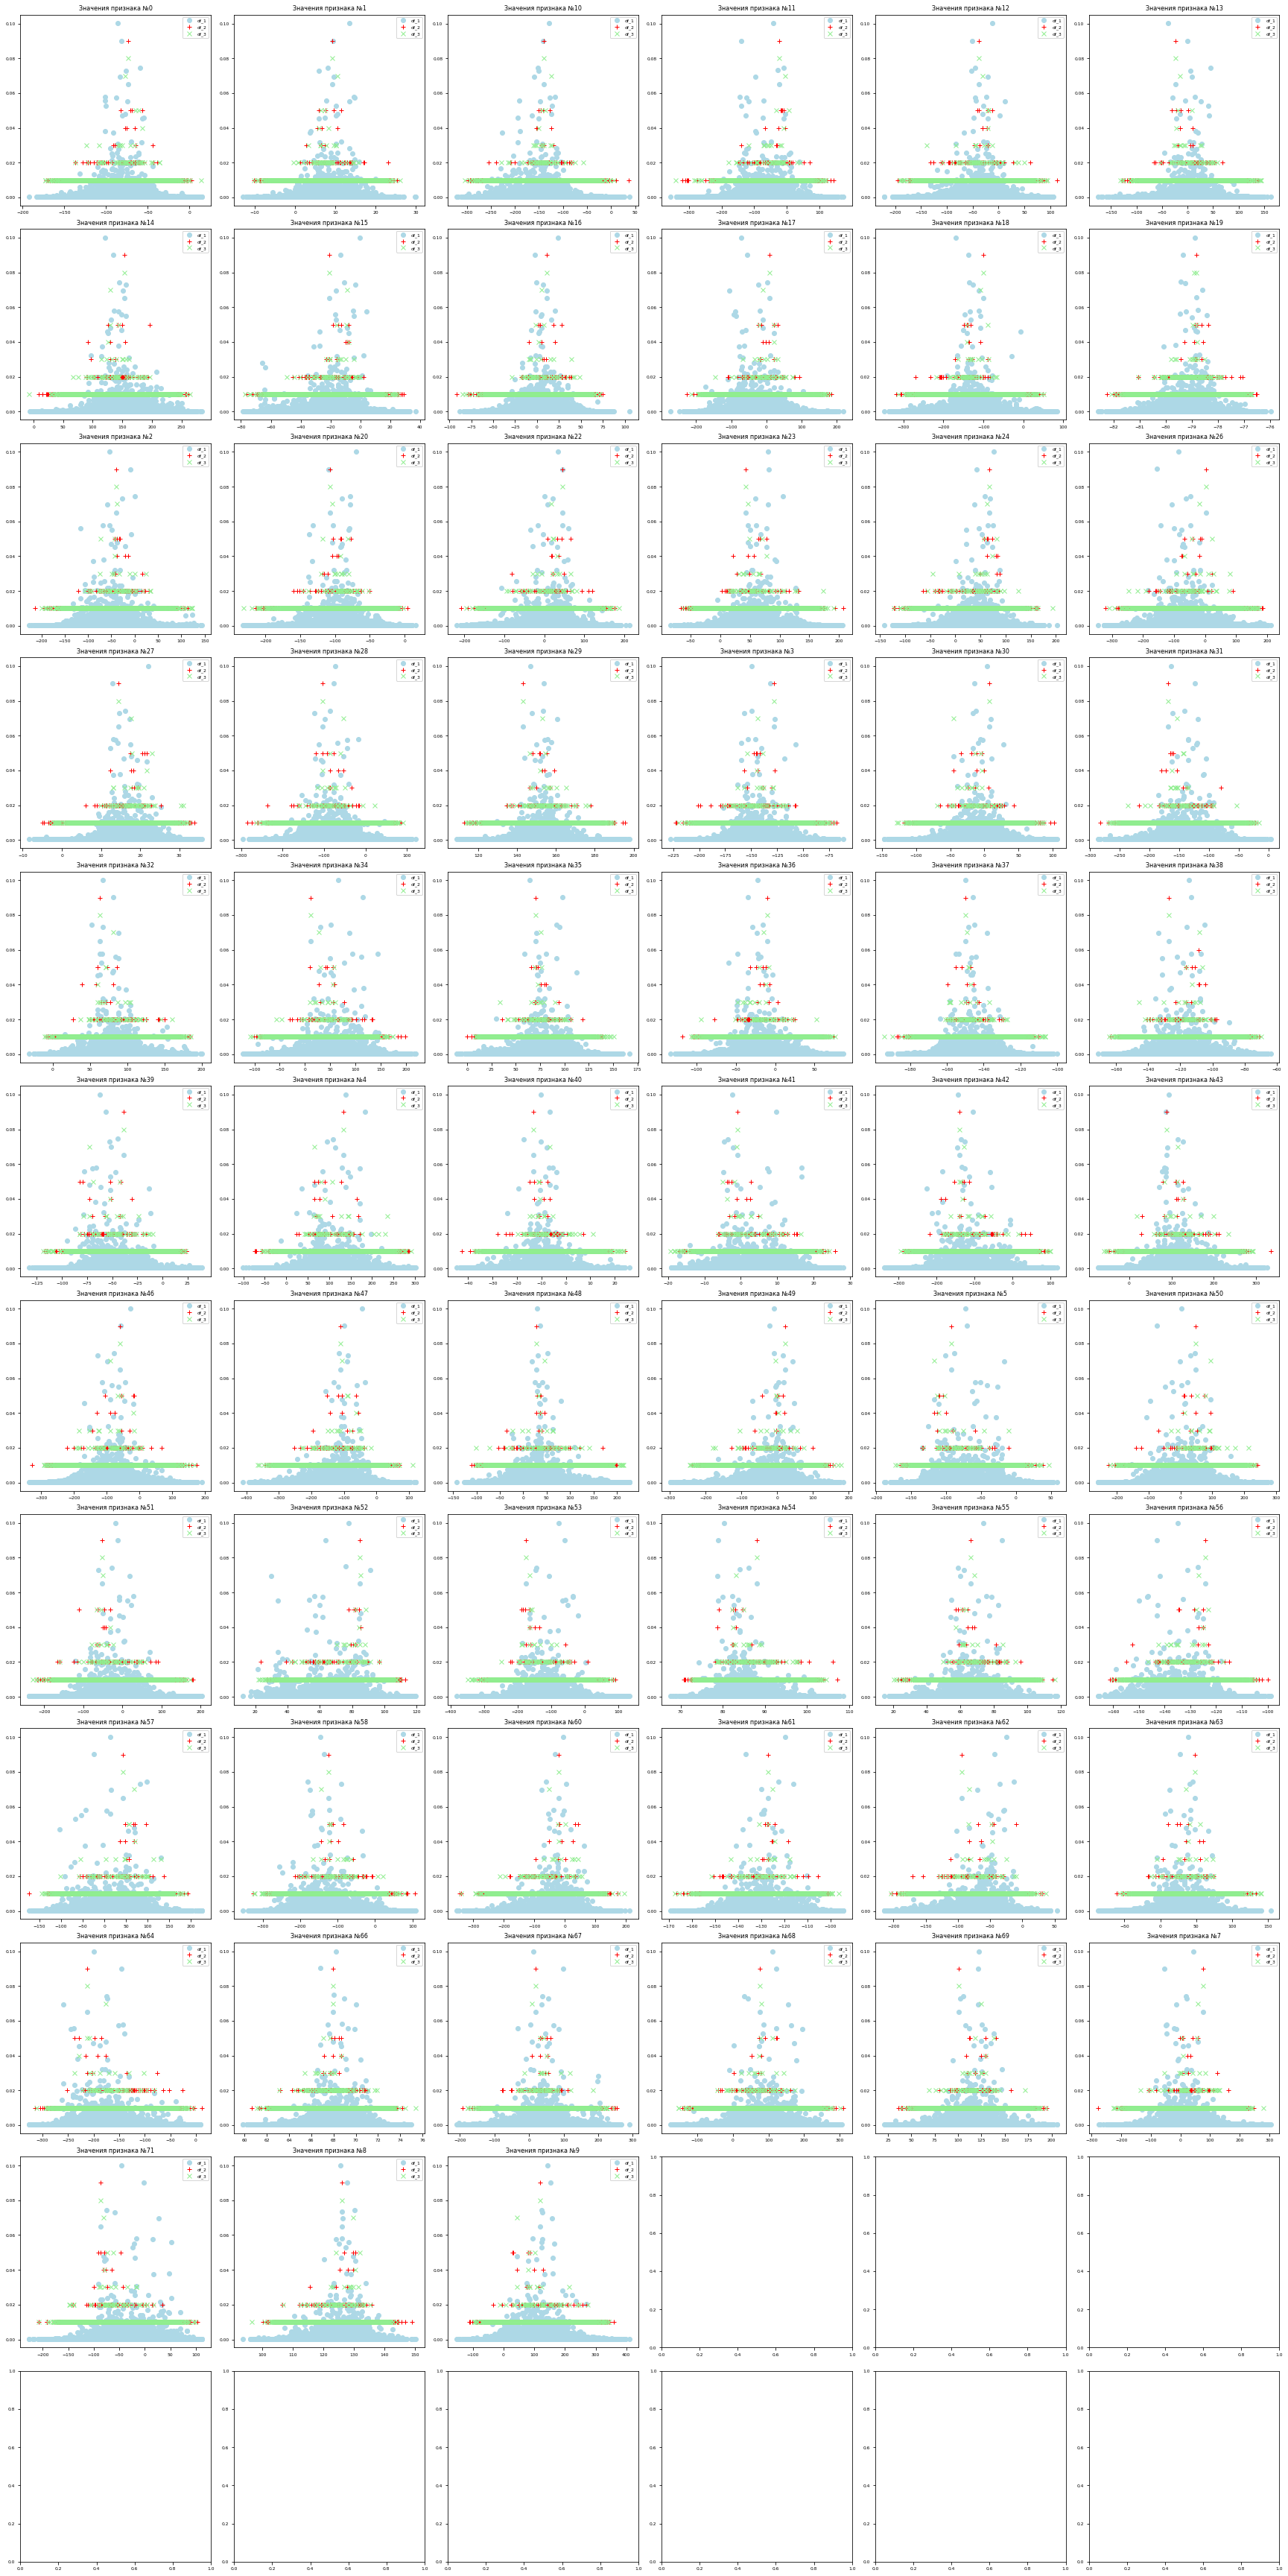

CPU times: user 44.6 s, sys: 764 ms, total: 45.4 s
Wall time: 44.7 s


In [ ]:
%%time
# вывод общей информации по всем датасетам
display(pd.DataFrame({'Датасет':['base_df', 'train_df', 'valid_df'],
                      'Цвет':['blue', 'red', 'green'],
                      'Символ':['.', '+', 'x']}))
show_general_matrix(base_df, train_df, valid_df)

`Valid_answer` - верные соответствующие товары для выборки Valid. Необходимо для тестирования обученной модели.

In [ ]:
display(valid_targets.head())
valid_targets.info()
print('Кол-во товаров-дубликатов:', valid_targets.duplicated().sum())

,expected
id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB
Кол-во товаров-дубликатов: 8498


### 1.4 Исследование мультиколлинеарности

Стоит проверить наличие зависимости между признаками, к примеру линейной и квадратичной. За это отвечают коэффициенты корреляции Пирсона и Фи, соответственно.

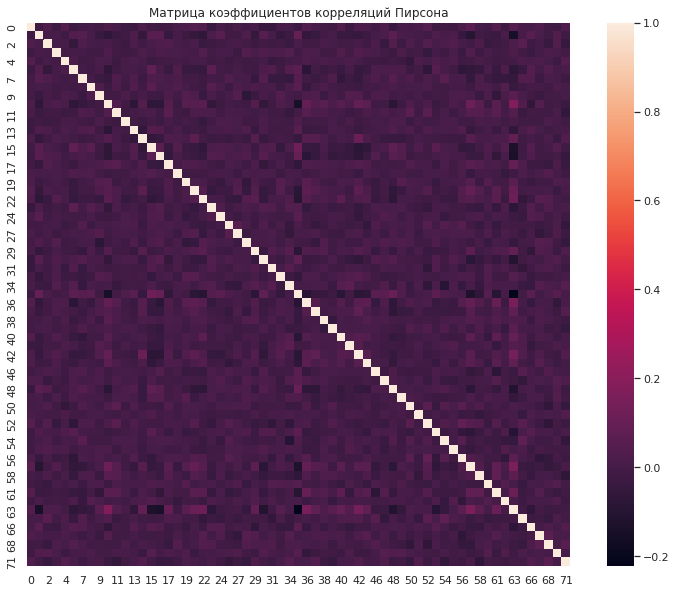

In [ ]:
# корреляций Пирсона
sns.set(rc = {'figure.figsize':(13, 10)})
sns.heatmap(base_df.corr(), square=True)
plt.title('Матрица коэффициентов корреляций Пирсона');

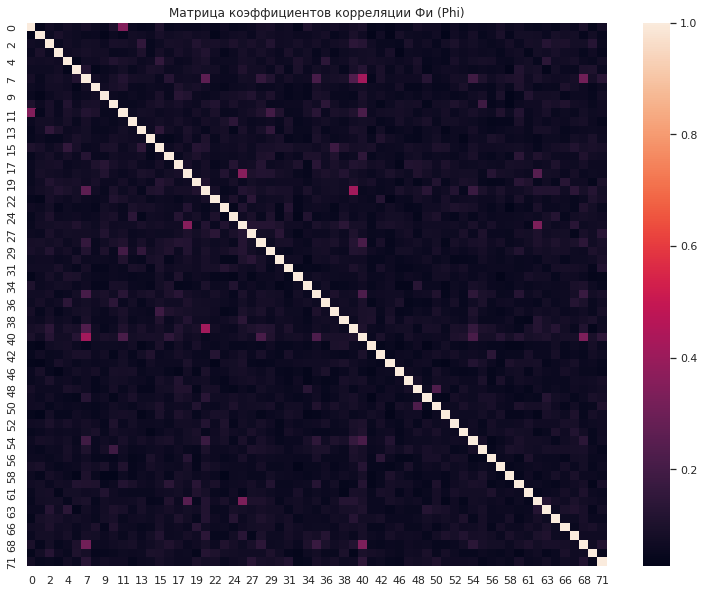

CPU times: user 44.7 s, sys: 3.07 s, total: 47.8 s
Wall time: 45.7 s


In [ ]:
%%time
# корреляции Фи
f, ax = plt.subplots(figsize=(13, 10))
phik_matrix = train_df.phik_matrix(interval_cols=train_df.columns)
sns.heatmap(phik_matrix)
plt.title('Матрица коэффициентов корреляции Фи (Phi)')
plt.show()

### **Промежуточный вывод:**

Тип данных - соответствует. Все значения - это числа с плавающий запятов типа `float64`, а id товаров - данные типа `object` или `string`.

Пропуски - отсутствуют.

Выбросы / аномалии - отсутствует. Существует разве что "дисбаланс" между значениями. А именно, некоторые значения встречаются особо часто в сравнении со всеми остальными. К примеру: для признака №25 особо популярен значение 813.770071. Оно встречается у ~80% товаров.

Дубликаты - отсутствуют, за исключением `Valid_answer`. Это может говорить, что одному и тому же "старому" товару, может соответствовать несколько "новых".

Явная зависимость между признаками - отсутствует. Всех их можно считать уникальными характеристиками товара.

Значения признаков сильно отличаются друг от друга. Они могут быть как положительными, так и отрицательными. Могут занимать широкий или узкий числовой диапазон. Для того чтобы каждый признак изначально имел одинаковую значимость необходимо произвести **Масштабирование**.

___

## Этап 2. Масштабирование признаков

In [ ]:
# Инициализация и обучение scaler
scaler = StandardScaler()
scaler.fit(base_df)

# Трансформация данных
base_transform  = scaler.transform(base_df)
train_transform = scaler.transform(train_df)
valid_transform = scaler.transform(valid_df)

# Создание DataFrame из трансформированных данных
base_transform  = pd.DataFrame(base_transform,  columns=base_df.columns,  index=base_df.index)
train_transform = pd.DataFrame(train_transform, columns=train_df.columns, index=train_df.index)
valid_transform = pd.DataFrame(valid_transform, columns=valid_df.columns, index=valid_df.index)

Данные готовы для применения.

___

##  Этап 3. Поиск ближайших соседей

- Отбор топ-100 кандидатов на основе косинусного расстояния;

- Используем библиотеку Faiss.

Принцип работы [Faiss](https://faiss.ai/index.html):
1. Отображение всех объектов (векторов) в едином пространстве;
2. Деление полученного пространства на отдельные части (кластеры) при помощи спец. алгоритма библиотеки;
3. Для каждого кластера происходит поиск его центра (центроида);
4. Таким образом, для нового вектора можно быстрой найти ближайших соседей, вычислив расстояние именно до центроидов (не перемножая новый вектор со всеми остальными векторами);
5. После выявления ближайшего кластера, новый вектор перемножается векторами только из этого кластера.

In [ ]:
# Функция `np.ascontiguousarray()` располагает последовательно весь массив данных в оперативной памяти.
base_vectors = np.ascontiguousarray(base_transform.values).astype('float32')

# Это обеспечивает оптимизацию доступа к данным и ускоряет последующие вычисления.
target_vectors = np.ascontiguousarray(train_transform.values).astype('float32')

In [ ]:
# Создание индекса для быстрого поиска с использованием указанной метрики внутреннего произведения.
# base_transform.shape[1] указывает размерность векторов, которые будут индексироваться.
index = faiss.index_factory(base_transform.shape[1], "Flat", faiss.METRIC_INNER_PRODUCT)

# Нормализация векторов base_vectors по L2-норме для обеспечения единичной длины.
# Это улучшает качество сравнения векторов при использовании внутреннего произведения.
faiss.normalize_L2(base_vectors)

# Добавление нормализованных векторов базы данных в индекс для последующего поиска.
index.add(base_vectors)

# Аналогичная нормализация векторов target_vectors перед поиском.
faiss.normalize_L2(target_vectors)

nprobs = 100  # Количество ближайших соседей для поиска

# Выполнение поиска в индексе для каждого из векторов в target_vectors.
# Возвращает расстояния и индексы nprobs наиболее близких соседей для каждого вектора.
distances, indexes = index.search(target_vectors, nprobs)

In [ ]:
# Инициализация переменной для подсчета точных совпадений
acc = 0

# Преобразование DataFrame train_targets в словарь для удобства доступа
target_indexes = train_targets.to_dict()

# Списки для сохранения индексов базовых векторов и целевых, которые совпали
pos_base_idxs = []
pos_target    = []

# Перебор целевых индексов и соответствующих им индексов ближайших соседей
for target_idx, idx in zip(target_indexes, indexes.tolist()):
    # Преобразование индексов ближайших соседей в соответствующие им значения индексов из base_transform
    base_vectors = [base_transform.index[i] for i in idx]

    # Проверка наличия целевого индекса среди индексов ближайших соседей
    if target_indexes[target_idx] in base_vectors:
        acc += 1                            # Увеличение счетчика точных совпадений
        pos_base_idxs.append(base_vectors)  # Добавление индексов совпавших соседей
        pos_target.append(target_idx)       # Добавление целевого индекса, который совпал

# Расчет и вывод процента точных совпадений
accuracy_percent = 100 * acc / len(train_targets)
print(accuracy_percent)

80.807


- Итого, рассчитав accuracy@100 получили 80,8 % верно определенных топ-100 похожив товаров на исходные из train.

## Этап 4. Ранжирование

- Используем библиотеку LightGBMRanker

Для обучения классификатора выберем только положительные результаты из предыдущего этапа, то есть те, где соответствие одного из топ-100 векторов исходному было верно определено.

In [ ]:
# Выборка позитивных примеров из train_transform, соответствующих найденным совпадениям
df_train_pos = train_transform.loc[train_transform.index.isin(pos_target)]

# Создание массива X, где каждый вектор из df_train_pos повторяется nprobs раз
# Это необходимо для последующего вычисления разности между векторами целевых и базовых данных
X = np.array(
    [[i] * nprobs for i in df_train_pos.values]).reshape(
    df_train_pos.shape[0] * nprobs, df_train_pos.shape[1]
)

# Создание массива X_idx, содержащего индексы повторяющихся векторов из df_train_pos
# Каждый индекс повторяется 100 раз (или nprobs раз, если изменить значение nprobs)
X_idx = np.array(
    [[idx] * 100 for idx in pos_target]).reshape(
    df_train_pos.shape[0] * nprobs
)

# Создание массива pos_base_100, содержащего значения базовых векторов для каждого совпадения
# Каждый набор базовых векторов повторяется для соответствующих целевых векторов
pos_base_100 = np.array(
    [base_transform.loc[i].values for i in pos_base_idxs]).reshape(
    df_train_pos.shape[0] * nprobs, df_train_pos.shape[1]
)

# Вычисление разности между целевыми векторами X и соответствующими базовыми векторами pos_base_100
# Это позволяет анализировать различия между сопоставленными векторами
X = X - pos_base_100

# Преобразование списка индексов базовых векторов в массив для последующей работы
pos_base_idxs = np.array(pos_base_idxs).reshape(df_train_pos.shape[0] * nprobs)

In [ ]:
# Инициализация пустого списка для хранения бинарных меток
y = []

# Перебор всех элементов в массиве X
for num in range(X.shape[0]):
    # Проверка соответствия между целевым вектором и базовым вектором
    # X_idx[num] - индекс в исходном наборе данных train_targets для текущего вектора из X
    # pos_base_idxs[num] - индекс соответствующего базового вектора
    # Если целевой вектор (определяемый через train_targets) соответствует базовому вектору, добавляется 1
    if train_targets[X_idx[num]] == pos_base_idxs[num]:
        y.append(1)
    else:
        # В противном случае добавляется 0, указывая на несоответствие
        y.append(0)

#### 4.1 Отбор гиперпараметров с помощью optuna

In [ ]:
# Разделение массива X на обучающее и тестовое подмножества
X_train, X_test = X[:2646400], X[2646400:]

# Разделение списка y на обучающее и тестовое подмножества аналогично массиву Xа
y_train, y_test = y[:2646400], y[2646400:]

In [ ]:
# Создание массива qids, каждый элемент которого представляет количество элементов (nprobs) в каждой группе запросов для всего набора данных X.
# Размер массива равен количеству групп запросов в X, где каждая группа включает 100 элементов.
qids = np.full((X.shape[0]//100), nprobs)

# Аналогичное создание массива qids_train для обучающего набора данных.
# Размер определяется количеством групп запросов в X_train, с каждой группой из 100 элементов.
qids_train = np.full((X_train.shape[0]//100), nprobs)

# Создание массива qids_test для тестового набора данных, аналогично qids и qids_train.
# Размер определяется количеством групп запросов в X_test.
qids_test = np.full((X_test.shape[0]//100), nprobs)

In [ ]:
def objective(trial):
    """
    Функция для оптимизации гиперпараметров модели LightGBM с использованием библиотеки Optuna.

    Аргументы:
    trial (optuna.trial.Trial): Испытание Optuna для генерации предложений гиперпараметров.

    Возвращает:
    float: Среднее значение метрики NDCG, полученное на тестовом наборе данных.

    Функция использует Optuna для предложения гиперпараметров, обучает модель LGBMRanker с этими параметрами
    на обучающем наборе данных и оценивает её на тестовом наборе данных. Целью оптимизации является максимизация
    среднего значения метрики NDCG (Normalized Discounted Cumulative Gain).
    """

    # Параметры для поиска с помощью Optuna
    param = {
        'reg_alpha': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),   # L1 регуляризация
        'reg_lambda': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),  # L2 регуляризация
        'max_depth': trial.suggest_int('max_depth', 3, 8),                     # Максимальная глубина деревьев
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),                 # Максимальное количество листьев в деревьях
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1),   # Доля фич, используемых при построении каждого дерева
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100)    # Минимальное количество данных в листе
    }

    # Обучение модели LGBMRanker с предложенными параметрами
    model = lightgbm.LGBMRanker(n_estimators=100, **param, random_state=123, verbose=-1)
    model.fit(
        X_train, y_train,
        group=qids_train,             # Группы для обучающего набора
        eval_set=[(X_test, y_test)],  # Тестовый набор данных для оценки
        eval_group=[qids_test],       # Группы для тестового набора
    )

    # Вычисление и возврат среднего значения NDCG
    scores = []
    for name, score in model.best_score_['valid_0'].items():
        scores.append(score)

    return np.mean(scores)

In [ ]:
# Установка уровня логирования для Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Создание исследования для оптимизации
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=42))  # Фиксированный seed для воспроизводимости
# Запуск оптимизации
study.optimize(objective, n_trials=10)  # Выполнение 10 испытаний для поиска лучших гиперпараметров

[1]	valid_0's ndcg@1: 0.566126	valid_0's ndcg@2: 0.592539	valid_0's ndcg@3: 0.604298	valid_0's ndcg@4: 0.612564	valid_0's ndcg@5: 0.618935
[2]	valid_0's ndcg@1: 0.581179	valid_0's ndcg@2: 0.617449	valid_0's ndcg@3: 0.633596	valid_0's ndcg@4: 0.643003	valid_0's ndcg@5: 0.649766
[3]	valid_0's ndcg@1: 0.613069	valid_0's ndcg@2: 0.652578	valid_0's ndcg@3: 0.6681	valid_0's ndcg@4: 0.677253	valid_0's ndcg@5: 0.683532
[4]	valid_0's ndcg@1: 0.632832	valid_0's ndcg@2: 0.673862	valid_0's ndcg@3: 0.689633	valid_0's ndcg@4: 0.698398	valid_0's ndcg@5: 0.704192
[5]	valid_0's ndcg@1: 0.643965	valid_0's ndcg@2: 0.686133	valid_0's ndcg@3: 0.701637	valid_0's ndcg@4: 0.71041	valid_0's ndcg@5: 0.71624
[6]	valid_0's ndcg@1: 0.654804	valid_0's ndcg@2: 0.697866	valid_0's ndcg@3: 0.71324	valid_0's ndcg@4: 0.721704	valid_0's ndcg@5: 0.727058
[7]	valid_0's ndcg@1: 0.664998	valid_0's ndcg@2: 0.708037	valid_0's ndcg@3: 0.722878	valid_0's ndcg@4: 0.730898	valid_0's ndcg@5: 0.736451
[8]	valid_0's ndcg@1: 0.672359	v

In [ ]:
# Получение лучших гиперпараметров после оптимизации
params = study.best_params

- В качестве вспомонательной метрики ранжирования использована метрика ndcg@k

In [ ]:
# Создание и обучение модели LGBMRanker с использованием лучших параметров
model = lightgbm.LGBMRanker(n_estimators=100, **params, random_state=123, verbose=-1)
model.fit(X,y,group=qids)

LGBMRanker(colsample_bytree=0.9455490474077702, lambda_l1=0.0008325158565947976,
           lambda_l2=4.609885087947832e-07, max_depth=8, min_child_samples=90,
           num_leaves=199, random_state=123, verbose=-1)

In [ ]:
# Делаем предсказания на основе признаков X
pred = model.predict(X, verbose=-1)  # verbose=-1 отключает логирование

# Создаем DataFrame с предсказаниями, используя индексы из X_idx
df_pred = pd.DataFrame(pred, index=X_idx)

# Добавляем в DataFrame столбец с исходными значениями целевой переменной
df_pred['target'] = y

# Группируем данные по индексу
# Для каждой группы сортируем записи по предсказаниям в убывающем порядке и выбираем топ-5
df_pred = df_pred.groupby(df_pred.index).apply(lambda x: x.sort_values([0], ascending=False).head(5))

# Сбрасываем индекс для упрощения структуры DataFrame
# Удаляем столбец 'level_0', который был добавлен в результате операции groupby().apply()
df_pred = df_pred.reset_index(level=[0]).drop('level_0', axis=1)

In [ ]:
def boosting_accuracy(df):
    """
    Рассчитывает точность модели бустинга для задачи ранжирования.

    Функция вычисляет процент групп (определяемых уникальным индексом),
    в каждой из которых среди топ-5 результатов присутствует хотя бы один с исходным значением целевой переменной, равным 1.

    Параметры:
    - df (pandas.DataFrame): DataFrame, содержащий предсказания и исходные значения целевой переменной.
      Индекс DataFrame должен указывать на принадлежность к определенной группе.
      Предполагается, что для каждой группы уже отобраны топ-5 предсказаний.

    Возвращает:
    - accuracy (float): Точность в процентах, показывающая долю групп, удовлетворяющих условию выше.
    """
    # Инициализация переменной для подсчета точности
    accuracy = 0

    # Перебор уникальных значений индексов, каждое из которых представляет собой группу
    for vec_name in df.index.unique().tolist():
        # Подсчет количества групп, где хотя бы одно предсказание с исходным значением целевой переменной равно 1
        accuracy += int(1 in df.loc[vec_name]['target'].tolist())

    # Расчет точности: отношение числа "успешных" групп к общему числу групп, умноженное на 100 для перевода в проценты
    return accuracy / (len(df) / 5) * 100

In [ ]:
lgbm_accuracy  = boosting_accuracy(df_pred)
lgbm_accuracy

92.65410174861088

Модель ранжирования предсказывает верно топ-5 векторов с точностью 96,2%. Это означает, что из всех векторов, которые модель рассматривает как верхние пять вариантов, 96,2% действительно являются правильными. Это можно записать как:

$$(P(\text{верный топ-5} | \text{предсказанный топ-5}) = 0,926)$$

Ранее отбранных верно 80,8%. Это вероятность того, что вектор, который модель отобрала как верный, действительно является верным. То есть:

$$(P(\text{верно отобранный} | \text{действительно верный}) = 0,808)$$

Теперь нужно найти общую точность модели. Мы можем использовать формулу условной вероятности:

$$(P(\text{верно отобранный}) = P(\text{верный топ-5} | \text{предсказанный топ-5}) \times P(\text{верно отобранный} | \text{действительно верный}))$$

$$(P(\text{верно отобранный}) = 0,926 \times 0,808)$$

Подставляем значения:

$$(P(\text{верно отобранный}) = 0,7482)$$

Таким образом, точность модели составляет около 74,82%.


## Этап 5. Проверка на тестовой выборке

Определение топ-100 ближаших соседей с помощью косинусного расстояния

In [ ]:
# Преобразование данных в массив NumPy с непрерывным расположением в памяти и типом данных float32.
valid_vectors = np.ascontiguousarray(valid_transform.values).astype('float32')

# Нормализация векторов так, чтобы их L2 норма (евклидова норма) была равна 1. Это улучшает сравнение векторов.
faiss.normalize_L2(valid_vectors)

# Поиск в индексе faiss для каждого вектора из valid_vectors. Возвращает nprobs ближайших соседей:
# distances_val - расстояния до ближайших соседей, indexes_val - индексы этих соседей.
distances_val, indexes_val = index.search(valid_vectors, nprobs)

In [ ]:
# Инициализация переменной для хранения суммы успешных совпадений
acc = 0

# Преобразование целевых значений в список для последующего использования
ans_dict = valid_targets.squeeze().to_list()

# Перебор каждой цели и соответствующих индексов из результатов поиска
for target, idx in zip(ans_dict, indexes_val.tolist()):
    # Получение базовых векторов по индексам из результатов поиска
    base_vectors = [base_transform.index[i] for i in idx]
    # Проверка, содержится ли целевое значение среди полученных базовых векторов
    if target in base_vectors:
        # Увеличение счетчика успешных совпадений, если целевое значение найдено
        acc += 1

# Расчет и вывод процента успешных совпадений от общего числа целей
print(100 * acc / len(train_targets))

80.698


Отбор топ-5 из топ-100

In [ ]:
# Создание массива X_val путем повторения каждого значения в valid_transform nprobs раз
# и последующей переформировкой в двумерный массив для соответствия форме valid_transform
X_val = np.array(
    [[i] * nprobs for i in valid_transform.values]).reshape(
    valid_transform.shape[0]*nprobs, valid_transform.shape[1]
)

# Создание массива индексов X_val_idx путем повторения каждого индекса из valid_transform nprobs раз
# и последующей переформировкой в одномерный массив
X_val_idx = np.array(
    [[idx] * nprobs for idx in valid_transform.index]).reshape(
    valid_transform.shape[0] * nprobs
)

# Создание массива base_100val путем выбора значений из base_transform по индексам, найденным в indexes_val
# и переформировкой результата в двумерный массив для соответствия форме valid_transform
base_100val = np.array([
    base_transform.iloc[i].values for i in indexes_val.tolist()]).reshape(
    valid_transform.shape[0]*nprobs, valid_transform.shape[1]
)

# Вычитание элементов массива base_100val из соответствующих элементов массива X_val
X_val = X_val - base_100val

# Создание массива base_indexes путем выбора индексов из base_transform по индексам, найденным в indexes_val
# и переформировкой результата в одномерный массив
base_indexes = np.array([base_transform.index[i] for i in indexes_val]).reshape(valid_transform.shape[0] * nprobs)

In [ ]:
# Инициализация пустого списка для хранения меток валидации
y_valid = []

# Перебор всех номеров строк в массиве X_val
for num in range(X_val.shape[0]):
    # Проверка условия: соответствует ли целевое значение для данной строки X_val
    # значению индекса в base_indexes для той же строки
    # valid_targets.squeeze()[X_val_idx[num]] извлекает целевое значение для текущей строки,
    # используя индекс из X_val_idx, и сравнивает его с соответствующим значением индекса в base_indexes
    if valid_targets.squeeze()[X_val_idx[num]] == base_indexes[num]:
        # Если значения совпадают, добавляем в y_valid 1 (положительный класс)
        y_valid.append(1)
    else:
        # Если значения не совпадают, добавляем в y_valid 0 (отрицательный класс)
        y_valid.append(0)

In [ ]:
# Предсказание моделью значений для данных X_val без вывода информации о процессе
pred_val = model.predict(X_val, verbose=-1)

In [ ]:
# Создаем DataFrame с предсказаниями, используя индексы из X_val_idx
df_pred_val = pd.DataFrame(pred_val, index=X_val_idx)

# Добавляем в DataFrame столбец с исходными значениями целевой переменной
df_pred_val['target'] = y_valid

# Группируем данные по индексу
df_pred_val = df_pred_val.groupby(df_pred_val.index).apply(lambda x: x.sort_values([0], ascending=False).head(5))

# Сбрасываем индекс для упрощения структуры DataFrame
df_pred_val = df_pred_val.reset_index(level=[0]).drop('level_0', axis=1)

In [ ]:
lgbm_accuracy  = boosting_accuracy(df_pred_val)
lgbm_accuracy

71.207

## Вывод

Для предасказания похожих векторов была использована двухэтапная модель машинного обучения.

1 этап - определение топ-100 с наименьшим косинусным расстояниям с помощью модели быстрого поиска ближайших соседей и кластеризации в векторном пространстве - Faiss.

2 этап - ранжирование топ-100 и определение топ-5 с помощью модели градиентого бустинга LightGBMRanker.

Точность итоговых предсказаний согласно ключевой метрики accuracy@5 - 71,2%.

---